<a href="https://colab.research.google.com/github/liang24w/ApplyAI-G1/blob/main/AI4All_Group_1_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
print(os.getcwd())
# Upload the kaggle.json file to the Colab environment
from google.colab import files
uploaded = files.upload()

# Set the environment variable for Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

/content


Saving Dataset.zip to Dataset.zip


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os.path

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [12]:
import torch
import zipfile
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split

with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_data')

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(num_output_channels=3)
])

In [13]:
dataset_root = "/content/extracted_data/Dataset"

# # counting total number of positive images
# DIR = '/content/extracted_data/Dataset/Positive'
# print (len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

dataset = ImageFolder(root=dataset_root, transform=transformations)

# Determine the size of the training set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and test sets
train_set, test_set = random_split(dataset, [train_size, test_size])

# Define classes
classes = ('Negative', 'Positive')

# Create DataLoader for training set
batch_size = 10
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

# Create DataLoader for test set
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# # Count the occurrences of the desired class in the entire dataset
# desired_class_count = 0
# for _, labels in train_loader.dataset:
#     desired_class_count += (labels == classes.index('Negative'))

# print(f"Number of images of class 'Negative': {desired_class_count}")

print("The number of images in a training set is: ", len(train_loader)*batch_size)
print("The number of images in a test set is: ", len(test_loader)*batch_size)
print("The number of batches per epoch is: ", len(train_loader))

The number of images in a training set is:  5230
The number of images in a test set is:  1310
The number of batches per epoch is:  523


In [14]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 2)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = F.relu(self.bn4(self.conv4(output)))
        output = F.relu(self.bn5(self.conv5(output)))

        output = output.view(-1, 24*10*10)

        output = self.fc1(output)

        return output

# Instantiate a neural network model
model = Network()


In [15]:
from torch.optim import Adam

# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [16]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():

    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):

    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):

            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 125 images
            running_loss += loss.item()     # extract the loss value
            if i % 125 == 124:
                # print every 125 (twice per epoch)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 125))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))

        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))

    # Show the real labels on the screen
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]]
                               for j in range(batch_size)))

    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

The model will be running on cpu device
[1,   125] loss: 0.232
[1,   250] loss: 0.200
[1,   375] loss: 0.132
[1,   500] loss: 0.135
For epoch 1 the test accuracy over the whole test set is 87 %
[2,   125] loss: 0.324
[2,   250] loss: 0.157
[2,   375] loss: 0.123
[2,   500] loss: 0.100
For epoch 2 the test accuracy over the whole test set is 95 %
[3,   125] loss: 0.068
[3,   250] loss: 0.070
[3,   375] loss: 0.069
[3,   500] loss: 0.066
For epoch 3 the test accuracy over the whole test set is 94 %
Finished Training


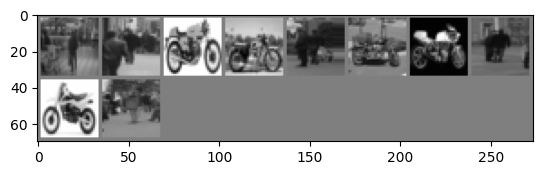

Real labels:  Positive Positive Negative Negative Positive Negative Negative Positive Negative Positive
Predicted:  Positive Positive Negative Negative Positive Negative Negative Positive Negative Positive


In [18]:
if __name__ == "__main__":

    # Let's build our model
    train(3)
    print('Finished Training')

    # Test which classes performed well
    testAccuracy()

    # Let's load the model we just created and test the accuracy per label
    model = Network()
    path = "myFirstModel.pth"
    model.load_state_dict(torch.load(path))

# this is the final TESTING
    # Test with batch of images
    testBatch()